# Setup Pong

In [1]:
from tqdm import tqdm
import numpy as np
import gym

In [2]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [3]:
env = gym.make("Pong-v4", render_mode="rgb_array")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [4]:
print(env.action_space)

Discrete(6)


In [5]:
print(env.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [6]:
env_recorder = VideoRecorder(env, path="./video.mp4", enabled=True)

In [7]:
print(env_recorder.env.observation_space)

Box(0, 255, (210, 160, 3), uint8)


# Preprocess Frames (the observation)

In [8]:
print(env_recorder.env.observation_space)

Box(0, 255, (210, 160, 3), uint8)


(210, 160, 3)


/Users/thomaslim/miniconda3/envs/rl_projects/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


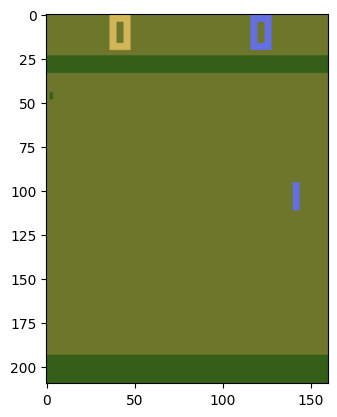

In [9]:
import matplotlib.pyplot as plt

env_recorder.env.seed(42)
env_recorder.env.reset()
random_frame = env_recorder.env.render()
print(random_frame.shape)
plt.imshow(random_frame)

In [10]:
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return observation_frame.astype(float)

(80, 80)


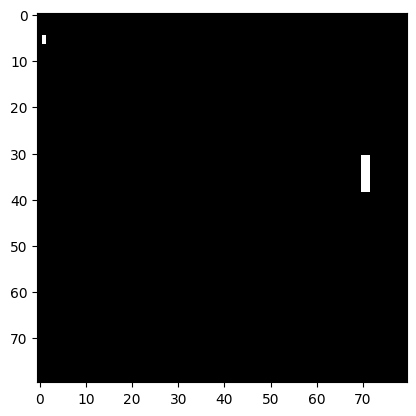

In [11]:
preprocessed_random_frame = frame_preprocessing(random_frame)
plt.imshow(preprocessed_random_frame, cmap="gray")
print(preprocessed_random_frame.shape)

# Create the policy (the neural network) and the forward pass

In [12]:
rng = np.random.default_rng(seed=12288743)

In [13]:
D = 80 * 80
H = 200
model = {}

In [14]:
model["W1"] = rng.standard_normal(size=(H, D)) / np.sqrt(D)
model["W2"] = rng.standard_normal(size=H) / np.sqrt(H)

In [15]:
def policy_forward(x, model):
    # Matrix-multiply the weights by the input in the one and only hidden layer.
    h = np.dot(model["W1"], x)
    # Apply non-linearity with ReLU.
    h[h < 0] = 0
    # Calculate the "dot" product in the outer layer.
    # The input for the sigmoid function is called logit.
    logit = np.dot(model["W2"], h)
    # Apply the sigmoid function (non-linear activation).
    p = sigmoid(logit)
    # Return a log probability for the action 2 ("move up")
    # and the hidden "state" that you need for backpropagation.
    return p, h

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def policy_backward(eph, epdlogp, epx, model):
    dW2 = np.dot(eph.T, epdlogp).ravel()  # Update for W2 using hidden states and action log prob gradients
    dh = np.outer(epdlogp, model["W2"])   # Compute gradient for hidden layer
    dh[eph <= 0] = 0  # Backprop through ReLU
    dW1 = np.dot(dh.T, epx)  # Update for W1 using input states (epx)
    # Return new optimized weights
    return {"W1": dW1, "W2": dW2}

In [16]:
# All preprocessed observations for the episode.
xs = []
# All hidden "states" (from the network) for the episode.
hs = []
# All gradients of probability actions
# (with respect to observations) for the episode.
dlogps = []
# All rewards for the episode.
drs = []

In [17]:
decay_rate = 0.99
grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}
rmsprop_cache = {k: np.zeros_like(v) for k, v in model.items()}

# Define the discounted rewards (expected return) function

In [18]:
gamma = 0.99

def discount_rewards(r, gamma):
    discounted_r = np.zeros_like(r)
    running_add = 0
    # From the last reward to the first...
    for t in reversed(range(0, r.size)):
        # ...reset the reward sum
        if r[t] != 0:
            running_add = 0
        # ...compute the discounted reward
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

# Train the agent for a number of episodes

In [19]:
def update_input(prev_x, cur_x, D):
    if prev_x is not None:
        x = cur_x - prev_x
    else:
        x = np.zeros(D)
    return x

In [20]:
max_episodes = 8000
batch_size = 3
learning_rate = 1e-4
render = False
observation = env_recorder.env.reset()[0]
prev_x = None
running_reward = None
reward_sum = 0
episode_number = 0

In [21]:
env_recorder = VideoRecorder(env, path=f'output_video_ep_{episode_number}.mp4', enabled=True) # this creates the video recorder for the 0th episode
while episode_number <= max_episodes:

    if render:
        env_recorder.env.render()

    cur_x = frame_preprocessing(observation).ravel()
    x = update_input(prev_x, cur_x, D)
    prev_x = cur_x

    aprob, h = policy_forward(x, model)
    action = 2 if rng.uniform() < aprob else 3

    xs.append(x)
    hs.append(h)

    y = 1 if action == 2 else 0
    dlogps.append(y - aprob)
    observation, reward, terminated, truncated, info = env_recorder.env.step(action)

    # Every 10 episodes, start recording the video.
    if episode_number % 1000 == 0:
        env_recorder.capture_frame()
    reward_sum += reward
    drs.append(reward)

    if terminated:
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)

        xs = []
        hs = []
        dlogps = []
        drs = []

        discounted_epr = discount_rewards(epr, gamma)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr
        grad = policy_backward(eph, epdlogp, epx, model)

        for k in model:
            grad_buffer[k] += grad[k]

        if episode_number % batch_size == 0:
            for k, v in model.items():
                g = grad_buffer[k]
                rmsprop_cache[k] = (
                    decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g ** 2
                )
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v)

        running_reward = (
            reward_sum
            if running_reward is None
            else running_reward * 0.99 + reward_sum * 0.01
        )
        if episode_number % 100 == 0:
            print(
                "Resetting the Pong environment. Episode {} total reward: {} Running mean: {}".format(
                    episode_number, reward_sum, running_reward
                )
            )

        reward_sum = 0
        observation = env_recorder.env.reset()[0]
        prev_x = None

        # Every 10 episodes, save the video.
        if episode_number % 1000 == 0:
            env_recorder.close() # This saves the video
            env_recorder = VideoRecorder(env, path=f'output_video_ep_{episode_number}.mp4', enabled=True) # this creates a new video
        episode_number += 1
    # if reward != 0:
    #     print(
    #         "Episode {}: Game finished. Reward: {}...".format(episode_number, reward)
    #         + ("" if reward == -1 else " POSITIVE REWARD!")
    #     )

env_recorder.close() # Get the last video

Resetting the Pong environment. Episode 0 total reward: -21.0 Running mean: -21.0
Moviepy - Building video output_video_ep_0.mp4.
Moviepy - Writing video output_video_ep_0.mp4



Moviepy - Done !
Moviepy - video ready output_video_ep_0.mp4


KeyboardInterrupt: 